0.014630794525146484


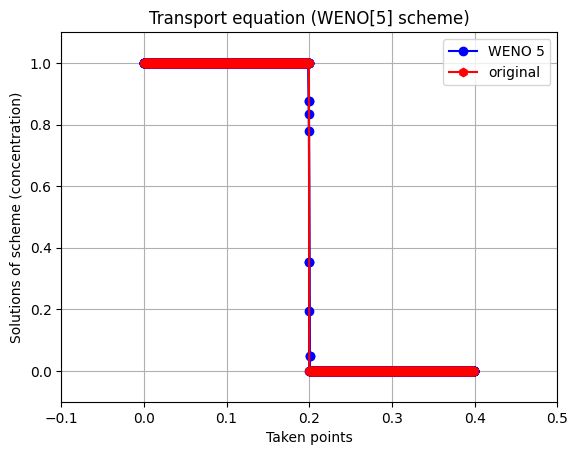

In [1]:
# https://pyweno.readthedocs.io/en/latest/tutorial.html !!!

#для решения уравнения переноса используется схема WENO 5-го порядка
import numpy as np
import matplotlib.pyplot as plt
import pylab
import time

N = 1000 #число рассматриваемых точек
S = 3  #число используемых шаблонов (для 5-го порядка используется 3-хточечная схема)
cur = 0.25 # коэффициент Куранта, должен быть меньше 1
x_left = 0
x_mid = 0.2
x_right = 0.4
v = 1
tau = 0
u1 = 1
u2 = 0
dx = (x_right - x_left)/N
dt = cur*dx/v
x = np.zeros(N, dtype = np.float64)
b = np.zeros((N,S), dtype=np.float64)
u = np.zeros((N, S), dtype=np.float64)
eps = 10**-6
# переменные для присваивания значений массивов для отрисовки графиков
u0 = np.zeros(N, dtype = np.float64)
uk = np.zeros(N, dtype = np.float64)

d = np.zeros(S, dtype=np.float64)
w = np.zeros(S, dtype=np.float64)
a = np.zeros(S, dtype=np.float64)
u_center = np.zeros((N,S), dtype=np.float64)
u_sol = np.zeros((N, S), dtype=np.float64)
u_0_1 = np.zeros(N, dtype=np.float64)
u_0_2 = np.zeros(N, dtype=np.float64)
u_0_3 = np.zeros(N, dtype=np.float64)
u_1_1 = np.zeros(N, dtype=np.float64)
u_1_2 = np.zeros(N, dtype=np.float64)
u_1_3 = np.zeros(N, dtype=np.float64)
u_2_1 = np.zeros(N, dtype=np.float64)
u_2_2 = np.zeros(N, dtype=np.float64)
u_2_3 = np.zeros(N, dtype=np.float64)

file = open('weno_solutions.txt', 'w')
starttime = time.time()
#начальные условия 
x[0] = x_left 
for s in range (S):
    for j in range (N-1):
        x[j+1] = x[j] + dx
        if x[j] <= x_mid:
              u[j, s] = u1
        else:
              u[j, s] = u2   
               
#_________________________________________________________________________________________________
# сетка для характеристик, направленных вправо
# индикаторы гладкости
for s in range (S - 1):
    for i in range(N-2):
        if s == 0:
            b[i, 0] = 13/12*((u[i, s] - 2*u[i+1, s] + u[i+2, s]))**2 + 1/4*(3*u[i, s] - 4*u[i+1, s] + u[i+2, s])**2
        if s == 1:
            b[i, 1] = 13/12*((u[i-1, s] - 2*u[i, s] + u[i+1, s]))**2 + 1/4*(u[i-1, s] - u[i+1, s])**2
        if s == 2:
            b[i, 2] = 13/12*((u[i-2, s] - 2*u[i-1, s] + u[i, s]))**2 + 1/4*(u[i-2, s] - 4*u[i-1, s] + 3*u[i, s])**2 

# числовые потоки, значения в середине ячеек
for s in range (S - 1):    
    for i in range (N-1):
        u_0_1[i] = -1/6*u[i, s] 
        u_1_1[i] = 1/3*u[i+1, s] + 5/6*u[i, s] 
        u_2_1[i] = 11/6*u[i, s]

for s in range (S - 1):
    for j in range(N-1):
        u_0_2[j] = 5/6*u[j, s]
        u_1_2[j] = - 1/6*u[j, s]
        u_2_2[j] = - 7/6*u[j, s]

for s in range (S - 1):
    for k in range(N-1):
        u_0_3[k] = 1/3*u[k, s]
        u_1_3[k] = 0
        u_2_3[k] = 1/3*u[k, s]

for z in range (N - 1):            
    u_center[z, 0] = u_0_1[z] + u_0_2[z] + u_0_3[z]
    u_center[z, 1] = u_1_1[z] + u_1_2[z] + u_1_3[z]
    u_center[z, 2] = u_2_1[z] + u_2_2[z] + u_2_3[z]   

# оптимальные коэффициенты
d[0] = 0.3
d[1] = 0.6
d[2] = 0.1

# веса
for s in range(S - 1):
    for i in range(N):
        a[s] = d[s]/(eps + b[i, s])**2

for s in range(S - 1):
    w[s] = a[s]/(a[0] + a[1] + a[2])

# решения для характеристик
for s in range (S - 1):
    for i in range(N):
            u_sol[i] = w[0]*u_center[i, 0] + w[1]*u_center[i, 1] + w[2]*u_center[i, 2]
            file.write(str(round(u_sol[i, s], 5)) + "\n")

#изменение графика в зависимости от временного слоя
tau = cur*((x_right - x_left)/v)
u_sol[0, 0] = u[0, 0]
for s in range (S - 1):
    for i in range (1, N):
        u_sol[i, s] = u_sol[i, s-1] - tau*v*((u_sol[i, s-1] - u_sol[i-1, s-1])/(x_right - x_left))
        x[i] = x[i-1] + dx

#эти циклы для того, чтобы в легенде названия графиков отображались по одному разу
for s in range (S -1):
    for i in range (N):
        u0[i] = u[i, s]

for s in range (S-1):
    for i in range (N):
        uk[i] = u_sol[i, s]

print(time.time() - starttime)

#вывод графика и запись полученных значений в текстовый файл  
pylab.xlim(-0.1, 0.5)
pylab.ylim(-0.1, 1.1)      
line1 = plt.plot (x, uk, 'b-o', label='WENO 5')
line1 = plt.plot (x, u_sol, 'b-o')
line2 = plt.plot (x, u0, 'r-h', label = 'original')
pylab.legend(loc = 'upper right')

file.close()
plt.title('Transport equation (WENO[5] scheme)')
plt.xlabel('Taken points')
plt.ylabel('Solutions of scheme (concentration)')
plt.grid(True)
plt.show()

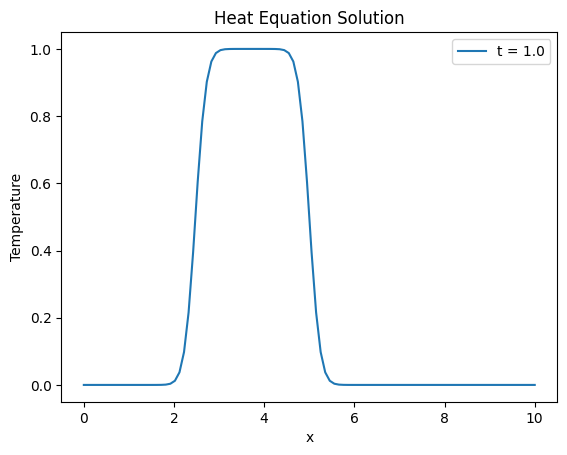

In [4]:
import numpy as np
from scipy.linalg import solve

# Параметры
L = 10.0        # Длина стержня
T = 1.0         # Общее время
Nx = 100         # Количество пространственных узлов
Nt = 10        # Количество временных шагов
alpha = 0.01    # Коэффициент теплопроводности

dx = L / (Nx - 1)
dt = T / Nt

# Инициализация температуры
u = np.zeros(Nx)
u_new = np.zeros(Nx)

# Начальные условия
u[int(Nx/4):int(Nx/2)] = 1.0  # Начальное распределение температуры

# Матрица коэффициентов
main_diag = (1 + 2 * alpha * dt / dx**2) * np.ones(Nx)
off_diag = (-alpha * dt / dx**2) * np.ones(Nx - 1)
A = np.diag(main_diag) + np.diag(off_diag, -1) + np.diag(off_diag, 1)

# Граничные условия (u = 0 на границах)
A[0, 0] = 1
A[-1, -1] = 1
A[0, 1] = 0
A[-1, -2] = 0

# Решение системы уравнений
for n in range(1, Nt + 1):
    b = u.copy()
    b[1:-1] = u[1:-1] + alpha * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])
    b[0] = 0  # Граничные условия
    b[-1] = 0

    u_new = solve(A, b)

    # Обновление температуры
    u = u_new.copy()

# Визуализация результата
import matplotlib.pyplot as plt

x = np.linspace(0, L, Nx)
plt.plot(x, u, label='t = {}'.format(T))
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title('Heat Equation Solution')
plt.legend()
plt.show()

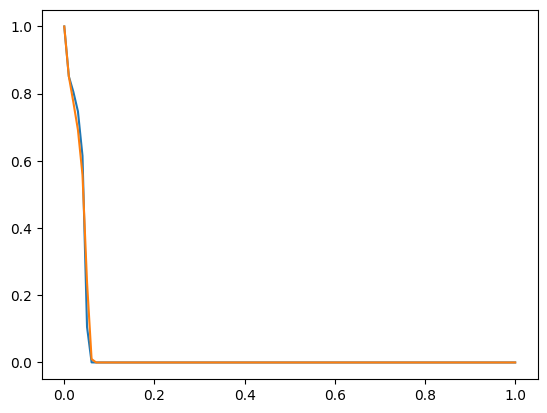

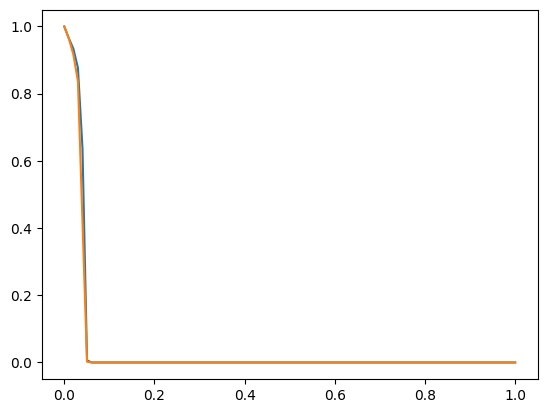

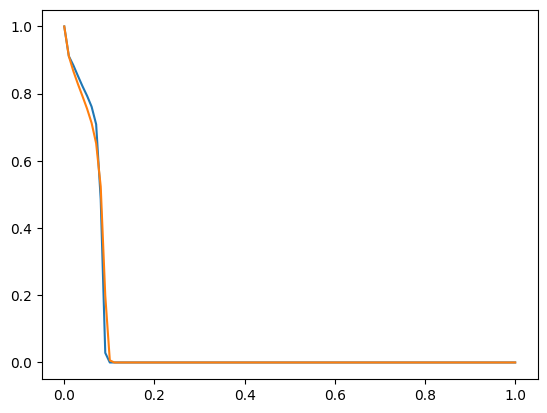

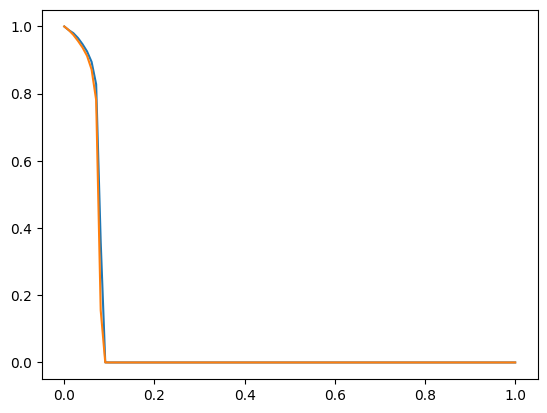

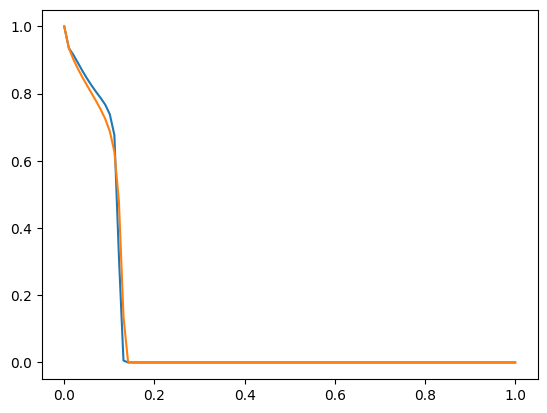

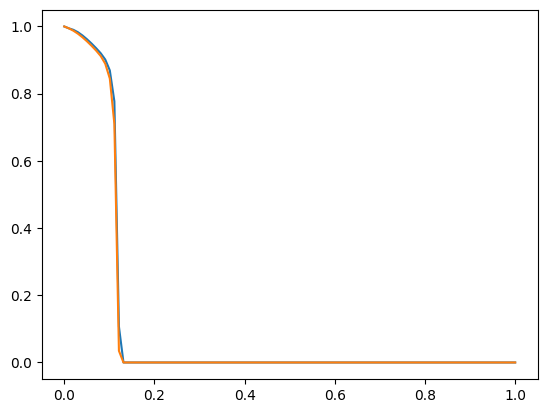

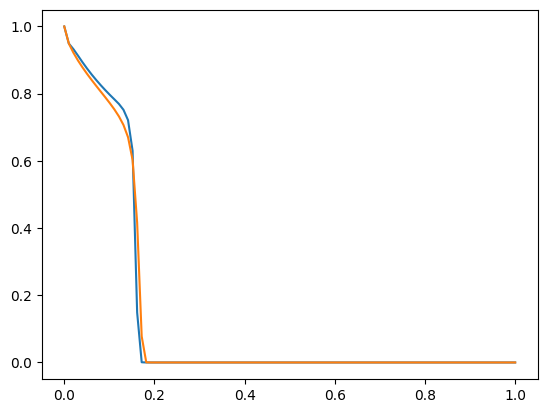

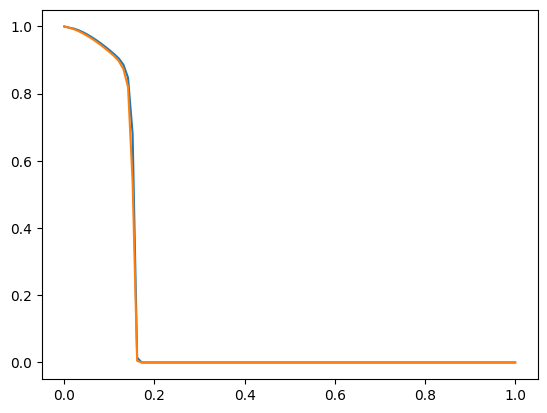

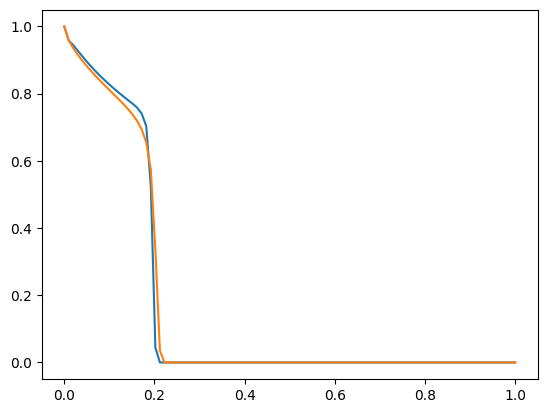

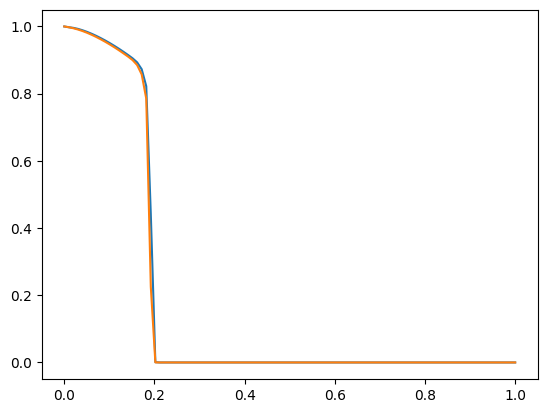

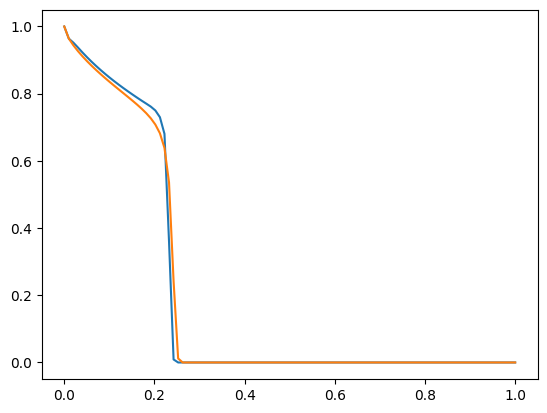

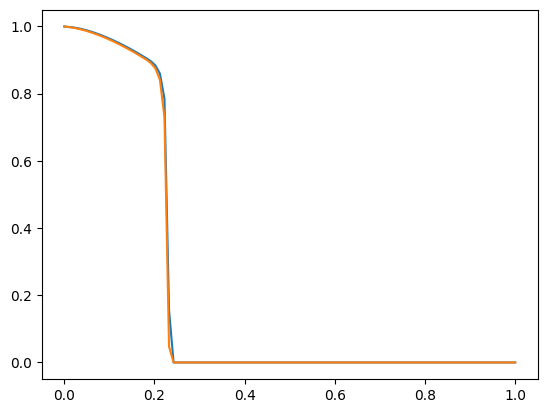

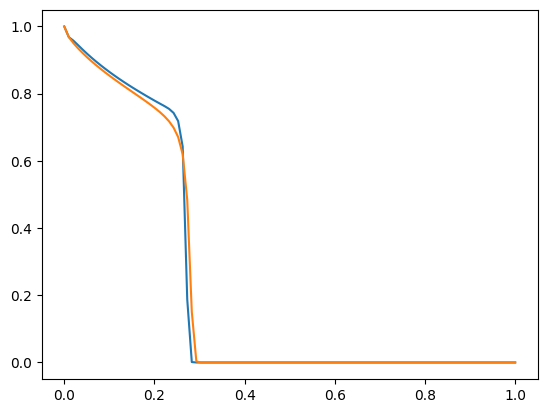

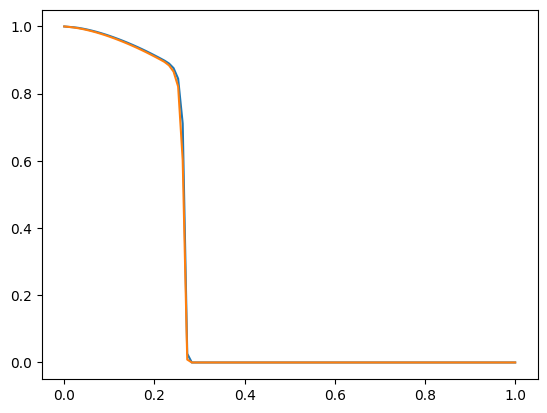

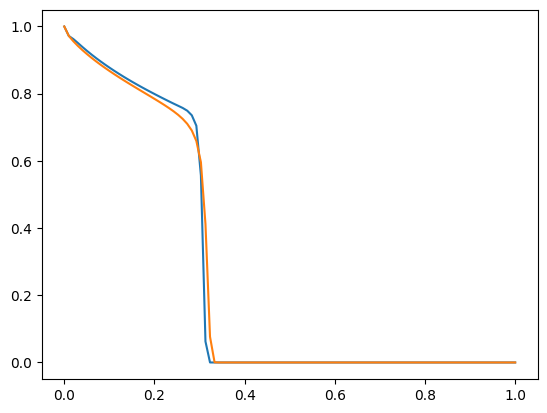

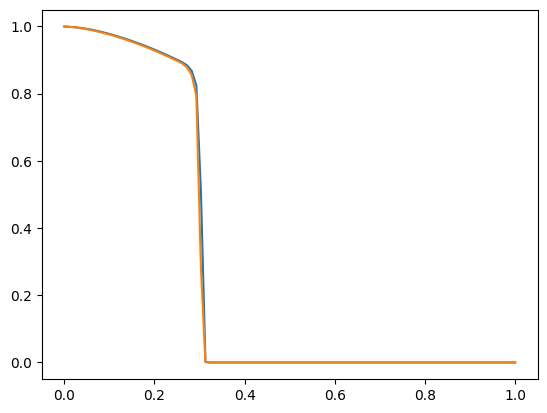

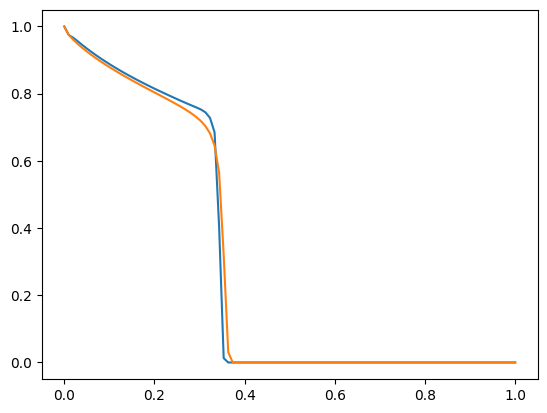

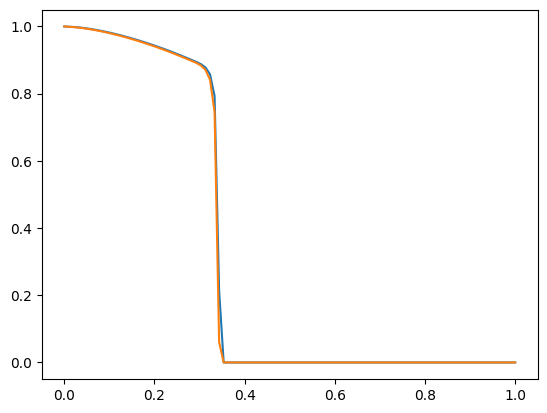

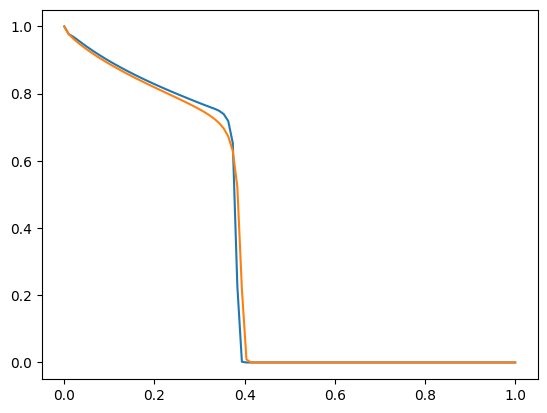

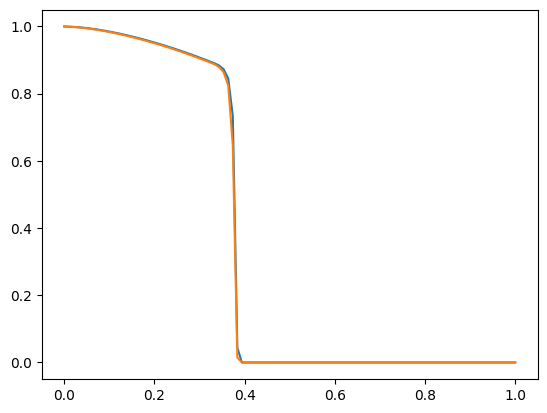

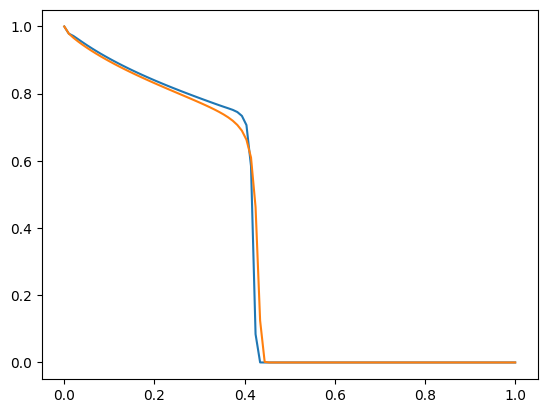

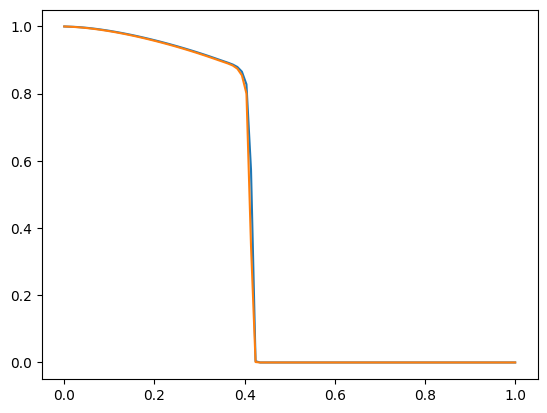

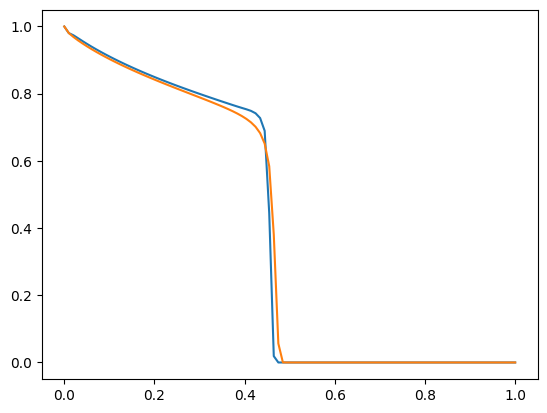

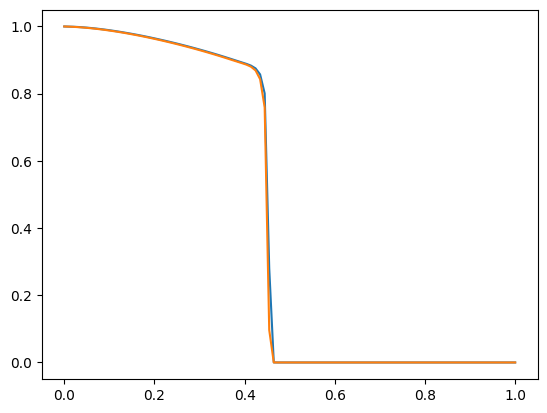

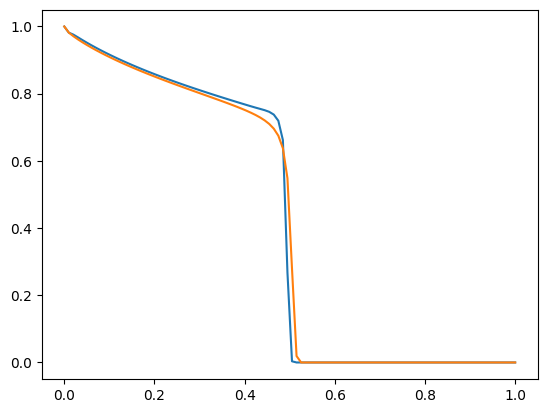

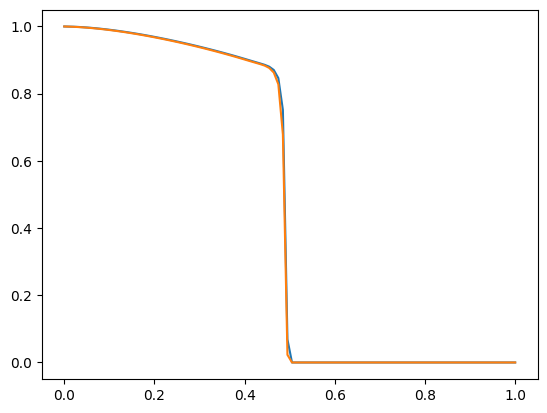

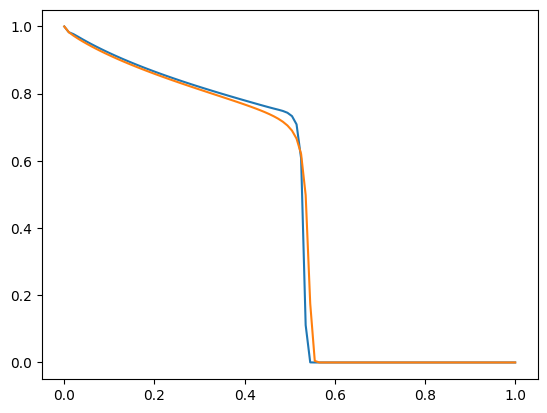

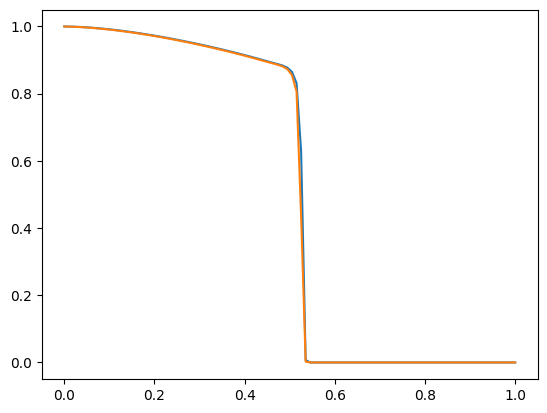

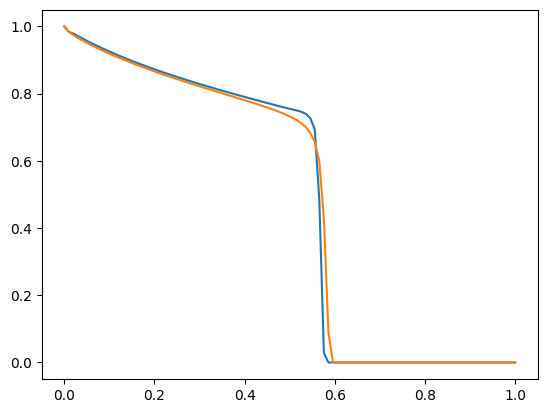

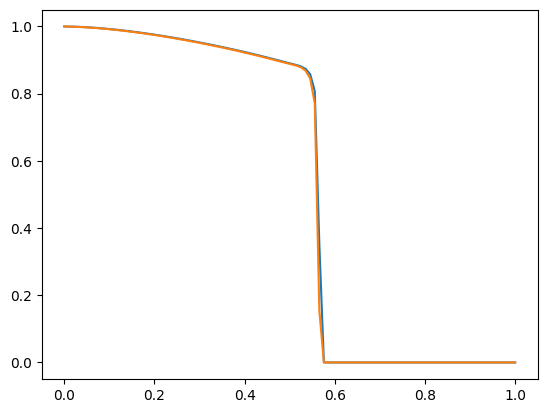

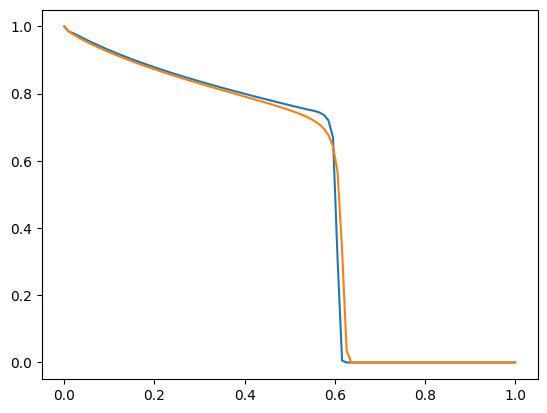

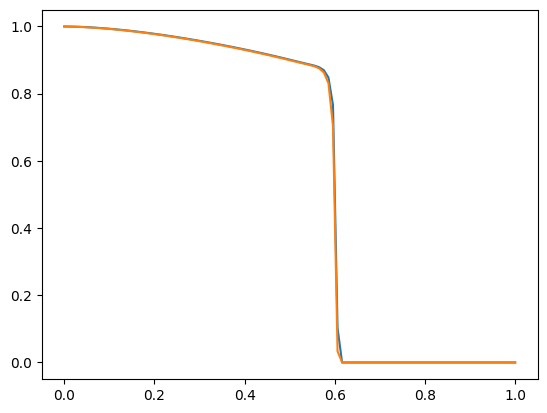

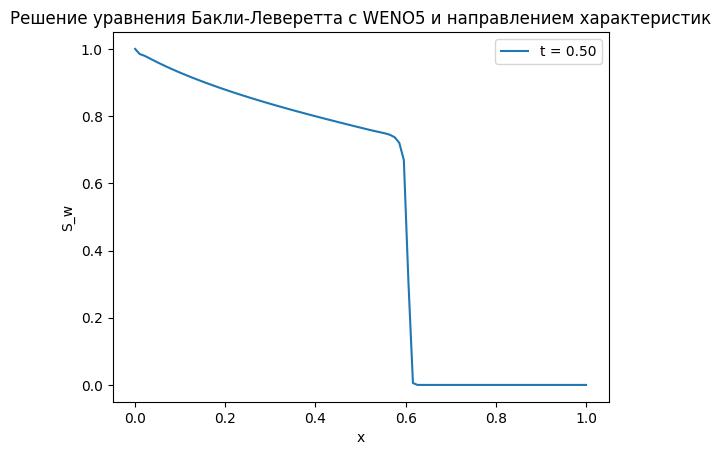

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from weno4 import weno4
# Параметры задачи
L = 1.0          # Длина области
Nx = 100         # Число узлов по пространству
T = 0.5          # Общее время моделирования
Nt = 800         # Число временных шагов
dx = L / Nx      # Шаг по пространству
dt = T / Nt      # Шаг по времени

# Параметры фракционного потока
def fw(Sw, krw0=0.3, kro0=0.7, nw=2, no=2, mu_w=1.0, mu_o=2.0):
    """ Функция фракционного потока воды """
    krw = krw0 * Sw**nw
    kro = kro0 * (1 - Sw)**no
    return (krw / mu_w) / (krw / mu_w + kro / mu_o)

# Производная фракционного потока для характеристик
def dfw_dSw(Sw, krw0=0.3, kro0=0.7, nw=2, no=2, mu_w=1.0, mu_o=2.0):
    """ Производная фракционного потока воды по насыщенности """
    krw = krw0 * Sw**nw
    kro = kro0 * (1 - Sw)**no
    dkrw_dSw = nw * krw0 * Sw**(nw-1)
    dkro_dSw = -no * kro0 * (1 - Sw)**(no-1)
    
    denom = (krw / mu_w + kro / mu_o)**2
    return (dkrw_dSw / mu_w * (krw / mu_w + kro / mu_o) - krw / mu_w * (dkrw_dSw / mu_w + dkro_dSw / mu_o)) / denom

# WENO5-схема для численного потока с учётом направления характеристик
def weno5_flux(Sw):
    flux = np.zeros_like(Sw)
    eps = 1e-6  # Для предотвращения деления на 0

    for i in range(2, len(Sw) - 2):
        # Левые потоки
        f1 = (2*Sw[i-2] - 7*Sw[i-1] + 11*Sw[i]) / 6
        f2 = (-Sw[i-1] + 5*Sw[i] + 2*Sw[i+1]) / 6
        f3 = (2*Sw[i] + 5*Sw[i+1] - Sw[i+2]) / 6

        # Веса для WENO
        beta1 = 13/12 * (Sw[i-2] - 2*Sw[i-1] + Sw[i])**2 + 1/4 * (Sw[i-2] - 4*Sw[i-1] + 3*Sw[i])**2
        beta2 = 13/12 * (Sw[i-1] - 2*Sw[i] + Sw[i+1])**2 + 1/4 * (Sw[i-1] - Sw[i+1])**2
        beta3 = 13/12 * (Sw[i] - 2*Sw[i+1] + Sw[i+2])**2 + 1/4 * (3*Sw[i] - 4*Sw[i+1] + Sw[i+2])**2

        alpha1 = 0.1 / (eps + beta1)**2
        alpha2 = 0.6 / (eps + beta2)**2
        alpha3 = 0.3 / (eps + beta3)**2

        w1 = alpha1 / (alpha1 + alpha2 + alpha3)
        w2 = alpha2 / (alpha1 + alpha2 + alpha3)
        w3 = alpha3 / (alpha1 + alpha2 + alpha3)

        flux[i] = w1 * f1 + w2 * f2 + w3 * f3
    flux[0] = Sw[0]
    flux[1] = Sw[1]
    flux[-1] = Sw[-1]
    flux[-2] = Sw[-2]
    return flux

def weno5_flux_with_direction(Sw, fw_values):
    flux = np.zeros_like(fw_values)
    eps = 1e-6  # Для предотвращения деления на 0

    # Производная фракционного потока для направления характеристик
    lambda_values = dfw_dSw(fw_values)

    for i in range(2, len(Sw) - 2):
        if lambda_values[i] > 0:
            # Левосторонний поток (характеристика направлена вправо)
            f1 = (2*Sw[i-2] - 7*Sw[i-1] + 11*Sw[i]) / 6
            f2 = (-Sw[i-1] + 5*Sw[i] + 2*Sw[i+1]) / 6
            f3 = (2*Sw[i] + 5*Sw[i+1] - Sw[i+2]) / 6
        else:
            # Правосторонний поток (характеристика направлена влево)
            f1 = (2*Sw[i+2] - 7*Sw[i+1] + 11*Sw[i]) / 6
            f2 = (-Sw[i+1] + 5*Sw[i] + 2*Sw[i-1]) / 6
            f3 = (2*Sw[i] + 5*Sw[i-1] - Sw[i-2]) / 6

        # Веса для WENO
        beta1 = 13/12 * (Sw[i-2] - 2*Sw[i-1] + Sw[i])**2 + 1/4 * (Sw[i-2] - 4*Sw[i-1] + 3*Sw[i])**2
        beta2 = 13/12 * (Sw[i-1] - 2*Sw[i] + Sw[i+1])**2 + 1/4 * (Sw[i-1] - Sw[i+1])**2
        beta3 = 13/12 * (Sw[i] - 2*Sw[i+1] + Sw[i+2])**2 + 1/4 * (3*Sw[i] - 4*Sw[i+1] + Sw[i+2])**2

        alpha1 = 0.1 / (eps + beta1)**2
        alpha2 = 0.6 / (eps + beta2)**2
        alpha3 = 0.3 / (eps + beta3)**2

        w1 = alpha1 / (alpha1 + alpha2 + alpha3)
        w2 = alpha2 / (alpha1 + alpha2 + alpha3)
        w3 = alpha3 / (alpha1 + alpha2 + alpha3)

        flux[i] = w1 * f1 + w2 * f2 + w3 * f3

    return flux

# Инициализация сетки
x = np.linspace(0, L, Nx)

Sw = np.zeros(Nx)
Sw[0] = 1.0  # Начальное условие (волна насыщенности воды)

Sw1 = np.zeros(Nx)
Sw1[0] = 1.0  # Начальное условие (волна насыщенности воды)

# Решение системы на каждом временном шаге
for n in range(1, Nt + 1):
    # Фракционная функция потока для текущей насыщенности
    fw_values = fw(Sw)
    fw_values1 = fw(Sw1)
    
    # Вычисляем численный поток с помощью WENO5 с учётом направления характеристик
    flux = weno5_flux(fw_values)
    flux1 = weno4(x, x, fw_values1)
    # Обновляем насыщенность с помощью явной схемы Эйлера
    Sw[1:] -= dt / dx * (flux[1:] - flux[:-1])
    Sw1[1:] -= dt / dx * (fw_values1[1:] - fw_values1[:-1])
    
    # Граничные условия
    Sw[0] = 1.0  # Впрыск воды с левой границы
    Sw[-1] = 0.0 # Правая граница остаётся ненасыщенной
    Sw1[0] = 1.0  # Впрыск воды с левой границы
    Sw1[-1] = 0.0 # Правая граница остаётся ненасыщенной
    if n%50==0:
        plt.plot(x, Sw, x, Sw1)
        plt.show()
        plt.plot(x, fw_values, x, flux)
        plt.show()

# Визуализация результата
plt.plot(x, Sw, label='t = {:.2f}'.format(T))
plt.xlabel('x')
plt.ylabel('S_w')
plt.title('Решение уравнения Бакли-Леверетта с WENO5 и направлением характеристик')
plt.legend()
plt.show()


In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import newton_krylov


# Параметры задачи
L = 1.0          # Длина стержня
T = 0.1          # Общее время
Nx = 50          # Число узлов по пространству
Nt = 100         # Число временных шагов
alpha = 0.01      # Коэффициент нелинейности в k(u) = 1 + alpha * u

dx = L / (Nx - 1)
dt = T / Nt

# Сетка по x
x = np.linspace(0, L, Nx)

# Инициализация температуры
u = np.zeros(Nx)
u_new = np.zeros(Nx)

# Начальное условие: температура равна 0 везде, кроме середины
u[int(Nx/2)] = 1.0

# Функция теплопроводности
def k(u):
    return  5*u**2

# Функция для построения матрицы и правой части
def build_system(u_old):
    # Матрица коэффициентов
    diagonals = [np.zeros(Nx-1), np.zeros(Nx), np.zeros(Nx-1)]

    # Правая часть
    b = u_old.copy()

    # Цикл по внутренним узлам
    for i in range(1, Nx - 1):
        k_i_plus = k(u_new[i])#(k(u_new[i]) + k(u_new[i+1])) / 2
        k_i_minus = k(u_new[i-1])#(k(u_new[i-1]) + k(u_new[i])) / 2

        aW = k_i_minus / dx**2
        aE = k_i_plus / dx**2
        aP = - (aW + aE) - 1.0 / dt

        diagonals[0][i] = aW     # нижняя диагональ (i-1)
        diagonals[1][i] = aP     # главная диагональ (i)
        diagonals[2][i] = aE     # верхняя диагональ (i+1)

        b[i] = -u_old[i] / dt

    # Применяем граничные условия
    diagonals[1][0] = 1.0
    diagonals[2][0] = 0.
    diagonals[1][-1] = 1.0
    diagonals[0][-2] = 0.

    b[0] = 0.1
    b[-1] = 0.1

    # Создаем разреженную матрицу
    A = diags(diagonals, offsets=[-1, 0, 1], format='csr')

    return A, b

# Система уравнений для Ньютона-Крылова
def system_krylov(u_old):
    def residual(u_new):
        A, b = build_system(u_old)
        return A.dot(u_new) - b
    return residual

# Решение системы с использованием Ньютона-Крылова
for n in range(Nt):
    u_old = u.copy()
    residual = system_krylov(u_old)
    u_new = newton_krylov(residual, u_old)
    u = u_new
    if n%10==0:
        plt.plot(x, u_new)
        plt.show()

# Визуализация результата
import matplotlib.pyplot as plt

plt.plot(x, u, label='t = {:.2f}'.format(T))
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title('Nonlinear Heat Conduction')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

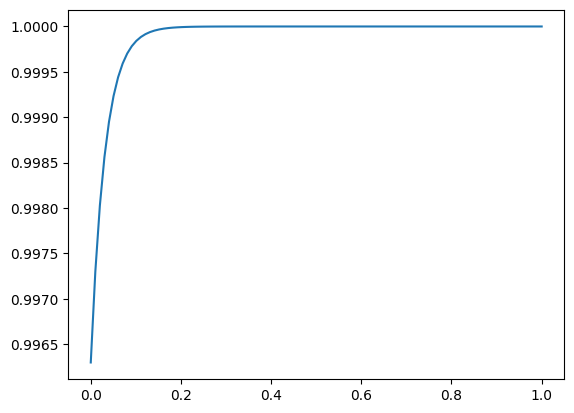

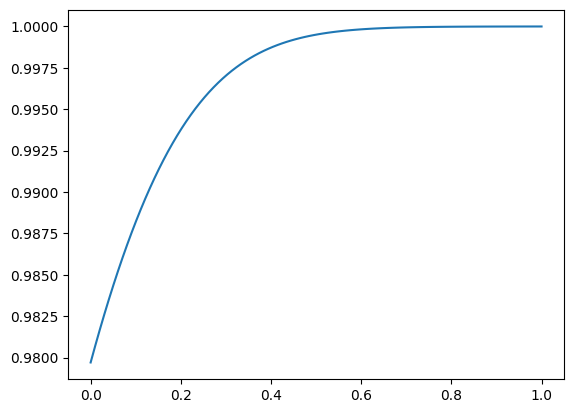

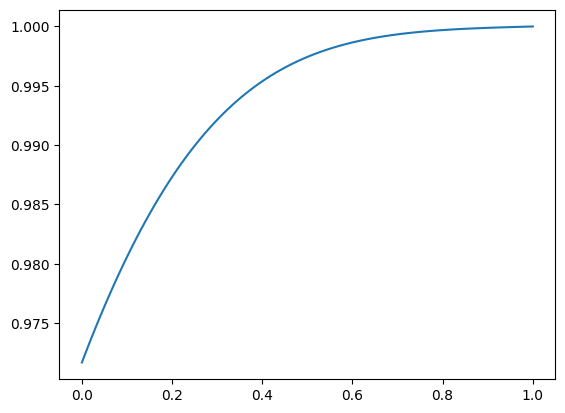

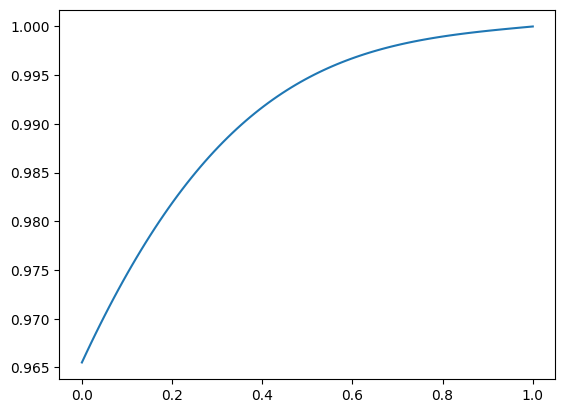

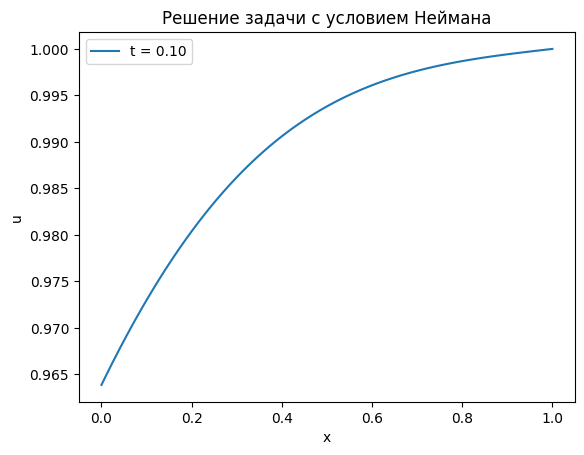

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Параметры задачи
L = 1.0                # Длина области
Nx = 100               # Число ячеек
dx = L / Nx            # Шаг по пространству
D = 1.0                # Коэффициент диффузии
T = 0.1                # Время моделирования
Nt = 100               # Число шагов по времени
dt = T / Nt            # Шаг по времени

# Пространственная сетка
x = np.linspace(0, L, Nx)

# Инициализация переменной u
u = np.zeros(Nx)+1

# Граничные условия Неймана
q_left = -0.1   # Поток на левой границе

# Коэффициенты неявной схемы
alpha = D * dt / dx**2

# Матрица для решения
diagonals = [-alpha * np.ones(Nx-1), (1 + 2*alpha) * np.ones(Nx), -alpha * np.ones(Nx-1)]
A = diags(diagonals, [-1, 0, 1]).tocsc()

# Модификация для условий Неймана на границах
A[0, 0] = -1
A[0, 1] = 1
A[-1, -1] = 1
A[-1, -2] = 0

# Основной цикл по времени
for n in range(Nt):
    # Правая часть
    b = u.copy()
    
    # Учет условий Неймана
    b[0] = -q_left * dx  # Левая граница
    b[-1] = 1 # Правая граница
    
    # Решение системы линейных уравнений
    u = spsolve(A, b)
    if n%30==0:
        plt.plot(x, u,)
        plt.show()

# Визуализация результата
plt.plot(x, u, label='t = {:.2f}'.format(T))
plt.xlabel('x')
plt.ylabel('u')
plt.title('Решение задачи с условием Неймана')
plt.legend()
plt.show()


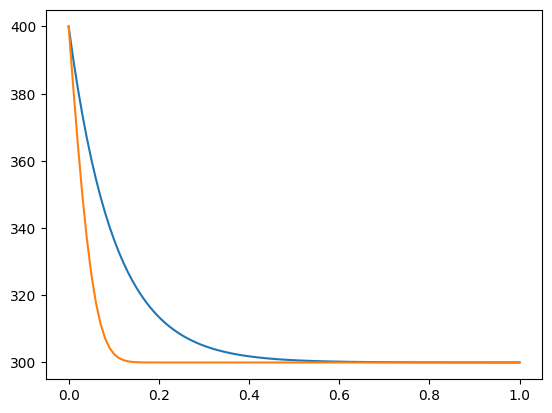

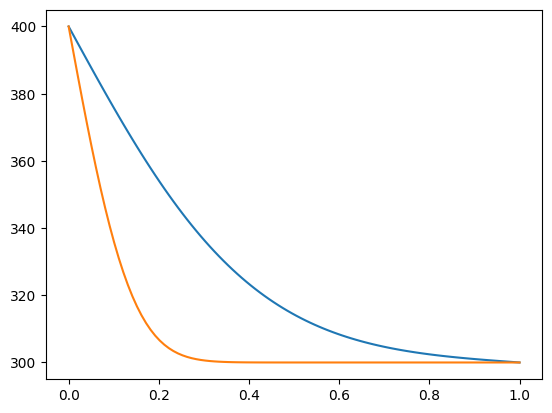

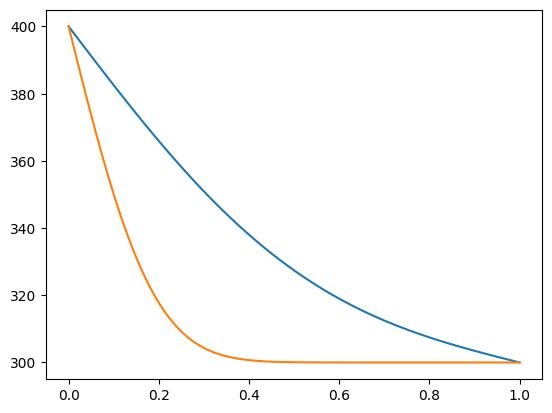

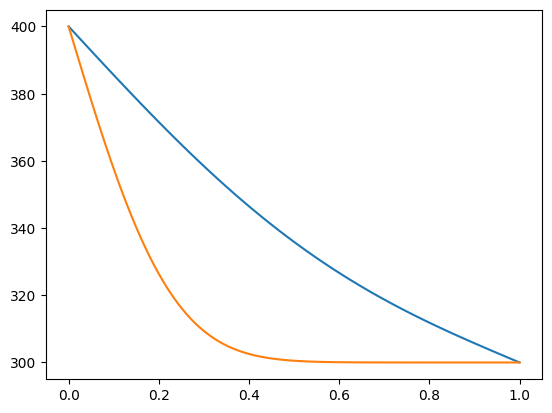

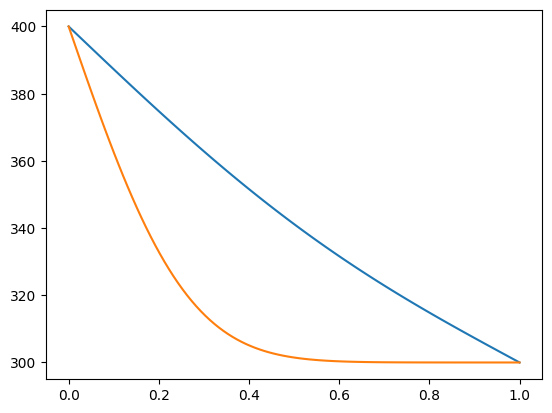

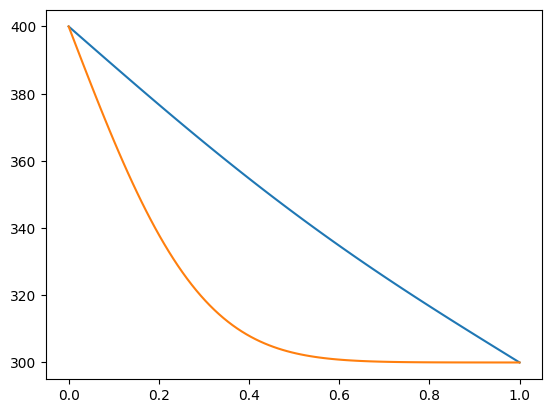

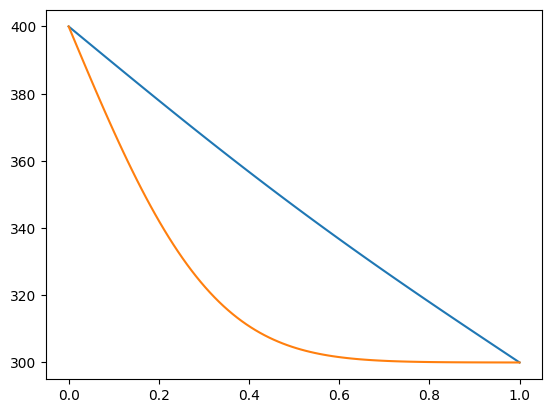

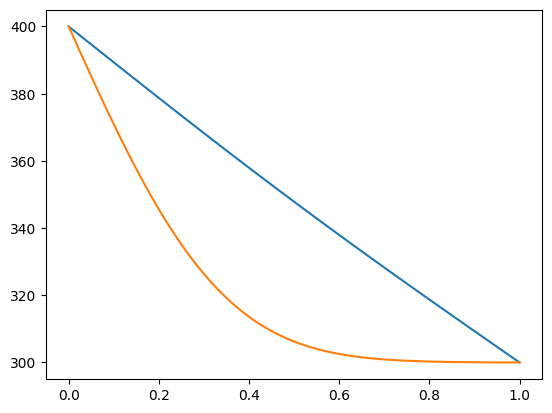

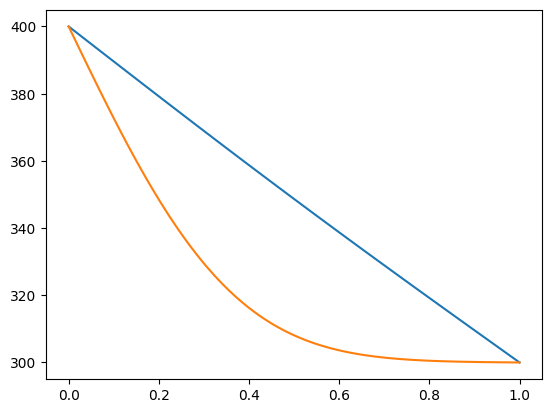

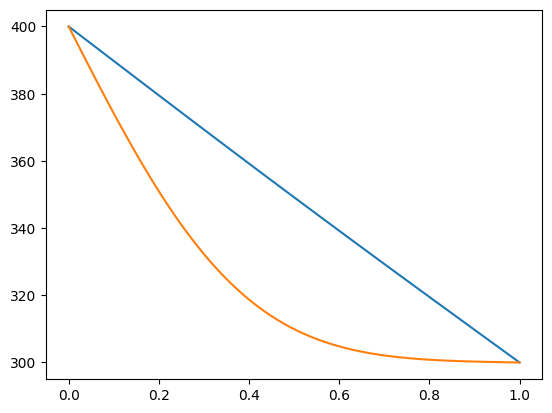

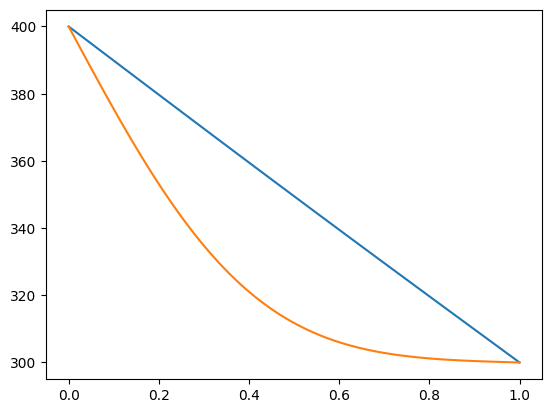

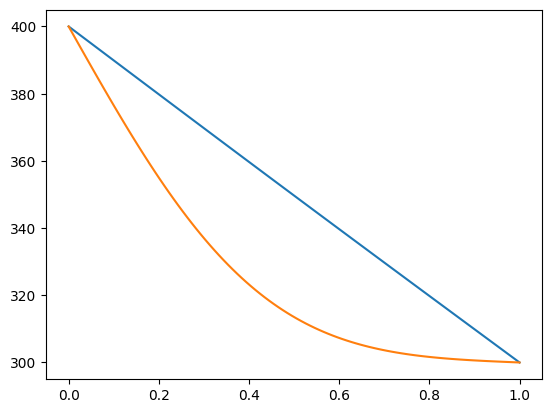

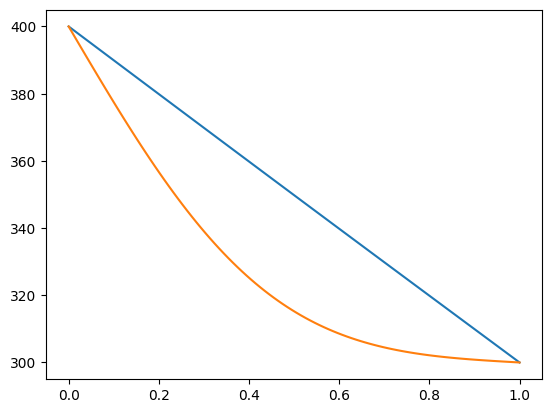

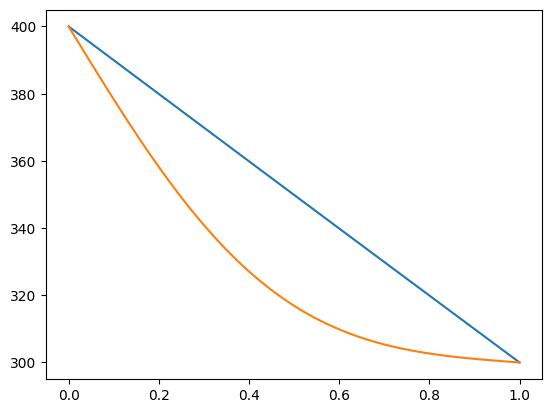

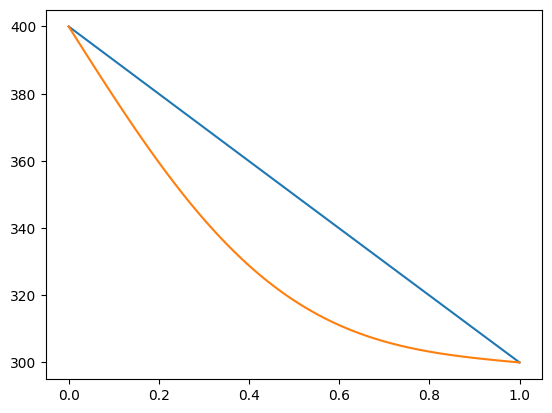

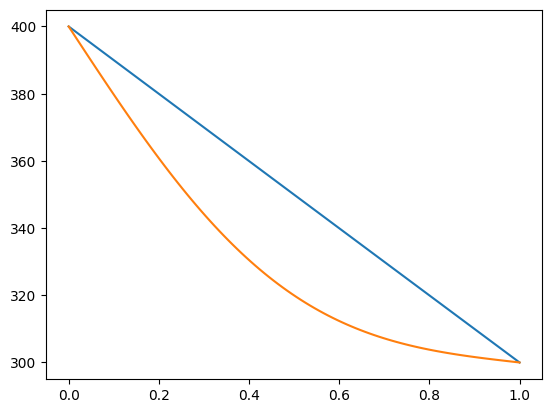

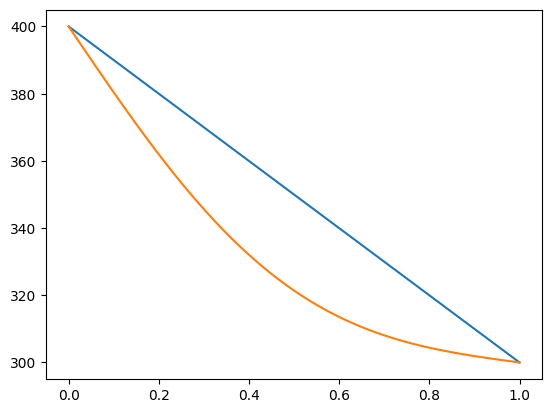

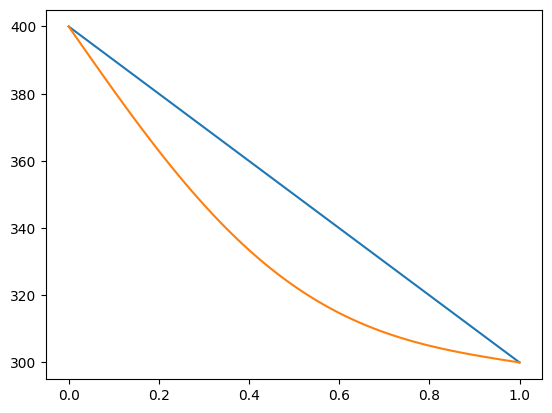

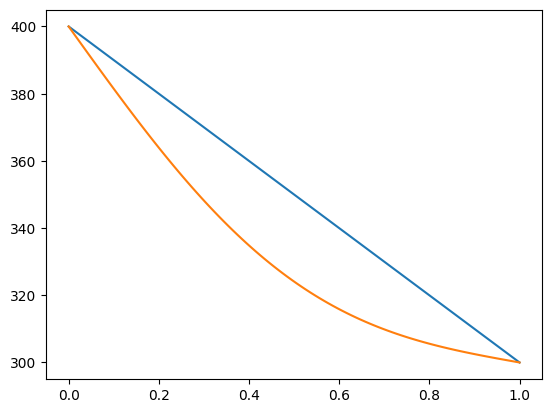

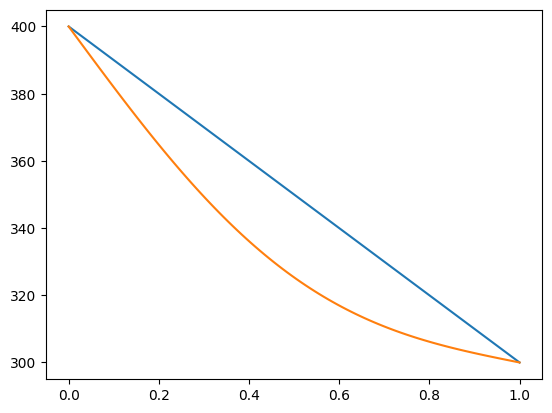

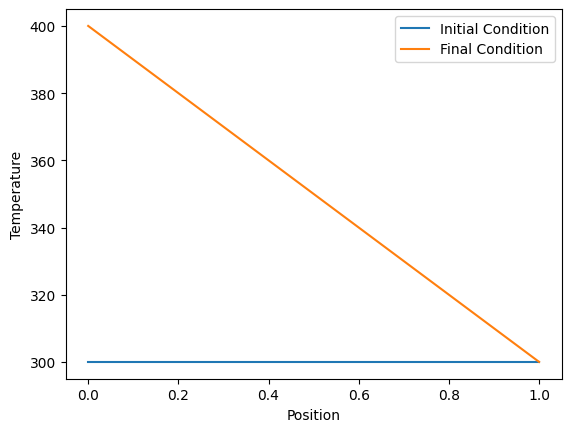

In [99]:
import numpy as np
from scipy.sparse import diags
from scipy.optimize import newton_krylov
import matplotlib.pyplot as plt

# Параметры задачи
L = 1.0  # длина стержня
N = 100  # количество узлов
dx = L / (N - 1)  # шаг по пространству
x = np.linspace(0, L, N)  # координаты

T0 = 300.0  # начальная температура
T_left = 400.0  # температура на левой границе (условие Дирихле)
T_right = 300.0  # температура на правой границе (условие Дирихле)

dt = 0.01  # шаг по времени
t_max = 1.0  # максимальное время

# Начальное условие (вся температура вначале равна T0)
u_initial = T0 * np.ones(N)

def initial_temperature(x):
    return np.zeros_like(x)+300   # пример начального распределения

# Точное решение уравнения теплопроводности
def exact_solution(x, t, alpha, L, N_terms=100):
    # Массив для хранения значений решения
    u_exact = np.zeros_like(x)
    
    # Вклад стационарного решения
    u_exact += T_left + (T_right - T_left) * (x / L)
    
    # Вклад временной части через ряды Фурье
    for n in range(1, N_terms + 1):
        lambda_n = n * np.pi / L
        C_n = 2 * np.trapz((initial_temperature(x) - (T_left + (T_right - T_left) * (x / L))) * np.sin(lambda_n * x), x) / L
        u_exact += C_n * np.sin(lambda_n * x) * np.exp(-alpha * lambda_n**2 * t)
    
    return u_exact

# Функция для коэффициента теплопроводности
def k_u(u):
    return np.tanh(u)**2  # пример зависимости теплопроводности от температуры

# Неявная схема: построение системы уравнений
def residual(u_new, u_old, dt, dx, k_u):
    """Выражение невязки для метода Ньютона-Крылова."""
    N = len(u_new)
    res = np.zeros(N)

    # Внутренние узлы (используем центральные разности)
    for i in range(1, N-1):
        k_left = (k_u(u_new[i-1]) + k_u(u_new[i])) / 2
        k_right = (k_u(u_new[i]) + k_u(u_new[i+1])) / 2
        res[i] = (u_new[i] - u_old[i]) / dt - \
                 (k_right * (u_new[i+1] - u_new[i]) / dx**2 - k_left * (u_new[i] - u_new[i-1]) / dx**2)
    
    # Граничные условия (Дирихле)
    res[0] = u_new[0] - T_left
    res[-1] = u_new[-1] - T_right

    return res

# Метод Ньютона-Крылова для решения нелинейной системы
def solve_nonlinear(u_old, dt, dx, k_u):
    """Решение системы уравнений с использованием метода Ньютона-Крылова."""
    u_new_guess = np.copy(u_old)  # начальное предположение
    u_new = newton_krylov(lambda u_new: residual(u_new, u_old, dt, dx, k_u), u_new_guess, method='lgmres')
    return u_new

# Основной цикл по времени
u = np.copy(u_initial)
t = 0
for i in range(int(t_max/dt)):
    u = solve_nonlinear(u, dt, dx, k_u)
    t+=dt
    if i%5==0:
        plt.plot(x, u)
        u_exact = exact_solution(x, t, 0.1, L, 200)
        plt.plot(x, u_exact, label=f't = {t}')
        plt.show()

# Визуализация результата
plt.plot(x, u_initial, label='Initial Condition')
plt.plot(x, u, label='Final Condition')
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.legend()
plt.show()


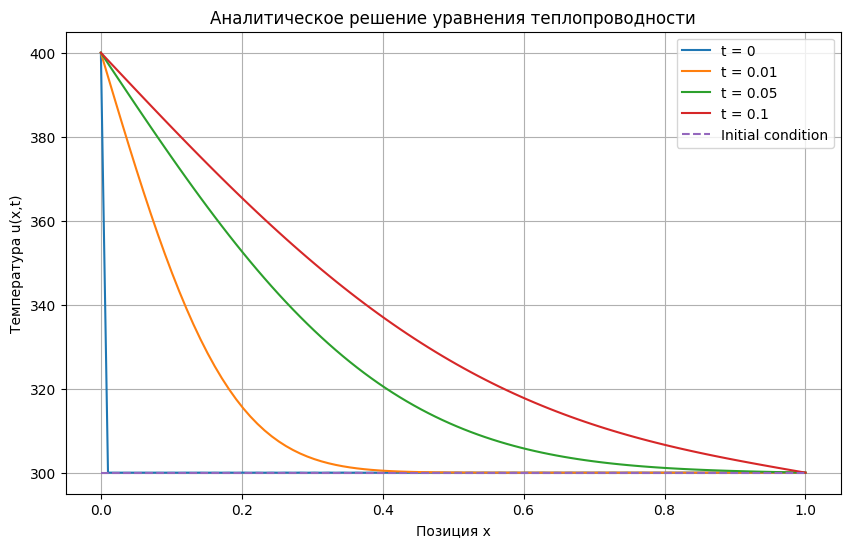

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
L = 1.0  # длина стержня
T_left = 400.0  # температура на левой границе
T_right = 300.0  # температура на правой границе
alpha = 1.0  # коэффициент теплопроводности
N_terms = 100  # количество членов ряда Фурье

# Функция начального распределения температуры
def initial_temperature(x):
    return np.zeros_like(x)+300   # пример начального распределения

# Точное решение уравнения теплопроводности
def exact_solution(x, t, alpha, L, N_terms=100):
    # Массив для хранения значений решения
    u_exact = np.zeros_like(x)
    
    # Вклад стационарного решения
    u_exact += T_left + (T_right - T_left) * (x / L)
    
    # Вклад временной части через ряды Фурье
    for n in range(1, N_terms + 1):
        lambda_n = n * np.pi / L
        C_n = 2 * np.trapz((initial_temperature(x) - (T_left + (T_right - T_left) * (x / L))) * np.sin(lambda_n * x), x) / L
        u_exact += C_n * np.sin(lambda_n * x) * np.exp(-alpha * lambda_n**2 * t)
    
    return u_exact

# Пространственная сетка
x = np.linspace(0, L, 100)

# Временные шаги для визуализации
time_points = [0, 0.01, 0.05, 0.1]

# Построение графиков точного решения на различных временных шагах
plt.figure(figsize=(10, 6))

for t in time_points:
    u_exact = exact_solution(x, t, alpha, L, N_terms)
    plt.plot(x, u_exact, label=f't = {t}')

# Начальное условие
plt.plot(x, initial_temperature(x), label='Initial condition', linestyle='--')

# Настройки графика
plt.title('Аналитическое решение уравнения теплопроводности')
plt.xlabel('Позиция x')
plt.ylabel('Температура u(x,t)')
plt.legend()
plt.grid(True)
plt.show()


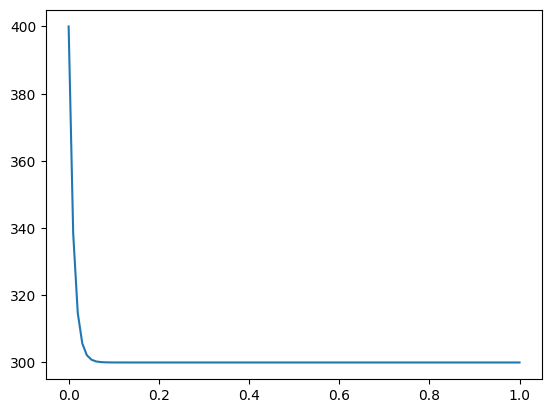

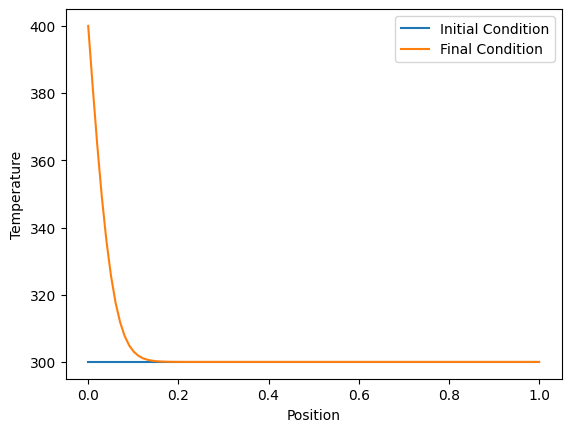

In [63]:
import numpy as np
from scipy.sparse import diags
from scipy.optimize import newton_krylov
import matplotlib.pyplot as plt

# Параметры задачи
L = 1.0  # длина стержня
N = 100  # количество узлов
dx = L / (N - 1)  # шаг по пространству
x = np.linspace(0, L, N)  # координаты

T0 = 300.0  # начальная температура
T_left = 400.0  # температура на левой границе (условие Дирихле)
T_right = 300.0  # температура на правой границе (условие Дирихле)

dt = 0.1 # шаг по времени
t_max = 1.0  # максимальное время

# Начальное условие (вся температура вначале равна T0)
u_initial = T0 * np.ones(N)

# Функция для коэффициента теплопроводности
def k_grad_u(grad_u):
    return grad_u  # пример зависимости теплопроводности от градиента

# Функция для аппроксимации разностной схемы
def residual(u, u_old, dx, dt, k_grad_u):
    """Функция невязки для метода Ньютона-Крылова."""
    N = len(u)

    # Создаем невязку
    res = np.zeros(N)
    
    # Внутренние точки
    # res[1:-1] = (u[1:-1] - u_old[1:-1]) / dt - \
    #             (k_right * (u[2:] - u[1:-1]) - k_left * (u[1:-1] - u[:-2])) / dx**2
    for i in range(1, N-1):
        grad_u_right = (u[i+1] - u[i]) / dx
        grad_u_left = (u[i] - u[i-1]) / dx
        k_right = k_grad_u(grad_u_right)
        k_left = k_grad_u(grad_u_left)
        res[i] = (u[i] - u_old[i]) / dt - \
                 (k_right * (u[i+1] - u[i]) / dx**2 - k_left * (u[i] - u[i-1]) / dx**2)
    
    # Граничные условия (Дирихле)
    res[0] = u[0] - T_left
    res[-1] = u[-1] - T_right
    
    return res

# Метод Ньютона-Крылова для решения нелинейной системы
def solve_nonlinear(u_old, dt, dx, k_u):
    """Решение системы уравнений с использованием метода Ньютона-Крылова."""
    u_new_guess = np.copy(u_old)  # начальное предположение
    u_new = newton_krylov(lambda u_new: residual(u_new, u_old, dt, dx, k_u), u_new_guess, method='lgmres')
    return u_new

# Основной цикл по времени
u = np.copy(u_initial)
t = 0
for i in range(int(t_max/dt)):
    u = solve_nonlinear(u, dt, dx, k_u)
    if i%10==0:
        plt.plot(x, u)
        plt.show()

# Визуализация результата
plt.plot(x, u_initial, label='Initial Condition')
plt.plot(x, u, label='Final Condition')
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.legend()
plt.show()

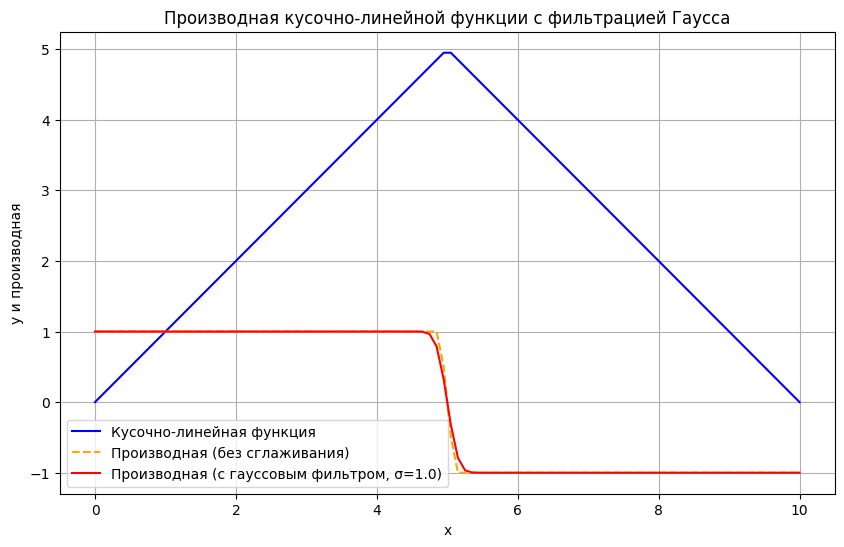

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Задаём сетку по x
x = np.linspace(0, 10, 100)

# Определяем кусочно-линейную функцию
y = np.piecewise(x, [x < 5, x >= 5], [lambda x: x, lambda x: 10 - x])

# Вычисление производной с использованием центральных разностей
dy_dx = np.gradient(y, x)

# Применяем гауссов фильтр для сглаживания производной
sigma = 1.0  # Параметр фильтрации (стандартное отклонение)
dy_dx_smooth = gaussian_filter1d(dy_dx, sigma=sigma)

# Визуализация результатов
plt.figure(figsize=(10, 6))

# Исходная кусочно-линейная функция
plt.plot(x, y, label='Кусочно-линейная функция', color='blue')

# Производная без сглаживания
plt.plot(x, dy_dx, label='Производная (без сглаживания)', linestyle='--', color='orange')

# Сглаженная производная
plt.plot(x, dy_dx_smooth, label=f'Производная (с гауссовым фильтром, σ={sigma})', color='red')

# Настройки графика
plt.title('Производная кусочно-линейной функции с фильтрацией Гаусса')
plt.xlabel('x')
plt.ylabel('y и производная')
plt.legend()
plt.grid(True)

# Показать график
plt.show()